* Algorithm

Input: 

Traning set $D = {(\mathbf{x_1}, y_1), (\mathbf{x_2}, y_2), ..., (\mathbf{x_m}, y_m)}$;

Base learner B;

Traning round T.
    
Process: 

1. $\displaystyle D_1 (\mathbf{x}) = \frac{1}{m}$.

2. $\mathbf{for} \quad t = 1, 2, ..., T \quad \mathbf{do}$

3. $\quad h_t = B(D, D_t)$;

4. $\quad \epsilon_t = P_{\mathbf{x} \sim D_t} (h_t(\mathbf{x}) \neq f(\mathbf{x}) ) $;

5. $\quad \text{if} \quad \epsilon_t > 0.5$ then break

6. $\quad \alpha_t = \frac{1}{2} ln(\frac{1-\epsilon_t}{\epsilon_t}) $;

7. $\quad D_{t+1} (\mathbf{x}) = \frac{D_{t} (\mathbf{x})}{Z_t} \times \left\{\begin{array}{ll}
                  exp(-\alpha_t), \quad \text{if} \quad h_t(\mathbf{x}) = f(\mathbf{x})\\
                  exp(\alpha_t), \quad \text{if} \quad h_t(\mathbf{x}) \neq f(\mathbf{x})
                \end{array} \right.\\
               \qquad \quad = \frac{D_t(\mathbf{x})exp(-\alpha_t f(\mathbf{x}) h_t(\mathbf{x}))}{Z_t}$
  
8. $\mathbf{end \quad for}$

Output:

$H(\mathbf{x}) = sign(\sum_{t=1}^{T} \alpha_th_t(\mathbf{x}))$


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m 
import collections
import pandas as pd
import sys 
import time


def readin_csv_data(path):
    df = pd.read_csv(path) 
    X = df.iloc[:,:-1].values 
    Y = df.iloc[:,-1].values 
    return X, Y

def train_test_split(X, Y, train_size, shuffle):
    ''' Perform tran/test datasets splitting '''
    if shuffle:
        randomize = np.arange(len(X))
        np.random.shuffle(randomize)
        X = X[randomize]
        Y = Y[randomize]
    s_id = int(len(Y) * train_size)
    X_train, X_test = X[:s_id], X[s_id:]
    Y_train, Y_test = Y[:s_id], Y[s_id:]

    return X_train, X_test, Y_train, Y_test    



def train_test_split_po(X, Y, train_size, shuffle):
    ''' Perform tran/test datasets splitting '''
    if shuffle:
        randomize = np.arange(len(X))
        np.random.shuffle(randomize)
        X = X[randomize]
        Y = Y[randomize]
    s_id = int(len(Y) * train_size)
    X_train, X_test = X[:s_id], X[s_id:]
    Y_train, Y_test = Y[:s_id], Y[s_id:]
    Y_train = Y_train.reshape((-1, 1))
    X_train1 = np.append(X_train, Y_train, axis = 1) 
    X_train1 = X_train1[np.argsort(X_train1[:, 0])]
    Y_test = Y_test.reshape((-1, 1))
    X_test1 = np.append(X_test, Y_test, axis = 1) 
    X_test1 = X_test1[np.argsort(X_test1[:, 0])]
    X_train, X_test = X_train1[:,:-1], X_test1[:,:-1]
    Y_train, Y_test = X_train1[:,-1], X_test1[:,-1]
    Y_train=np.squeeze(Y_train)
    Y_test=np.squeeze(Y_test)
    return X_train, X_test, Y_train, Y_test

def metric_accuracy(Y_label, Y_pred):
    '''Evaluate the accuracy'''
    correct_amount = 0 
    for i in range(np.size(Y_pred)) :   #np.size: Number of elements in the array
        if Y_label[i] == Y_pred[i] :             
            correct_amount = correct_amount + 1
    return correct_amount / np.size(Y_pred) * 100



class DecisionTree():
    '''Classification And Regression Tree 
    ------------------------------------
    Input data structure: numpy array with m x (d+1) shape, 
                          m rows of samples included, 
                          d columns of features/ttributes,
                          and 1 column of target
    Criterion: gini, entropy or mse'''
    
    
    def __init__(self, max_depth=None, min_samples=None, criterion=None, weight=None):
        self.md = max_depth
        self.ms = min_samples
        self.depth_init = 1
        self.criterion = criterion
        # Decision stump parameters
        self.w = weight # sample weights
        self.p = None      # polarity 
        self.threshod = None # node
        self.column_idx = None  # node feature index
        self.error = None   # Decision stump traning error
    
    def evaluate_information_entropy(self, p):
        '''Evaluate information entropy component'''
        if p==0:
            return 0
        elif p==1:
            return 0
        else:
            return -p*np.log2(p)
        
    def evaluate_information_gain(self, left, right, classes):
        '''Evaluate information gain'''
        IG_after = 0
        IG_before = 0
        size_l = left.shape[0]
        size_r = right.shape[0]
        size_t = size_l +  size_r # Total sample No.
        lr = np.vstack((left, right))
        statis_lr = collections.Counter(lr[:,-1])
        IG_before = sum([self.evaluate_information_entropy(float(statis_lr[class_i])/float(size_t)) for class_i in classes])
        spaces = [left, right]
        for space in spaces:
            size = space.shape[0] # Sample No. in different group
            if size == 0:   # Avoid 0 in denominator
                continue     
            tmp = 0.
            statis = collections.Counter(space[:,-1])
            tmp=sum([self.evaluate_information_entropy(float(statis[class_i])/float(size)) for class_i in classes])
            IG_after += tmp * (size / size_t)
        return IG_before - IG_after         
       
    def evaluate_gini_index(self, left, right, classes):
        '''Gini impurity for classification'''
        gini = 0
        size_l = left.shape[0]
        size_r = right.shape[0]
        size_t = size_l +  size_r # Total sample No.
        spaces = [left, right]
        for space in spaces:
            size = space.shape[0] # Sample No. in different group
            if size == 0:   # Avoid 0 in denominator
                continue     
            tmp = 0.
            statis = collections.Counter(space[:,-1])
            tmp=sum([(float(statis[class_i])/float(size))**2.0 for class_i in classes])
            gini += (1.0 - tmp) * (size / size_t)
        return gini    
    
    def evaluate_mse_index(self, left, right):
        '''MSE index for regression'''
        mse = 0
        spaces = [left, right]
        for space in spaces:
            mse += np.mean((space[:,-1] - np.mean(space[:,-1]))**2.)
        return mse    
    
    def node(self, X):
        '''split with the optimal gini, entropy, or mse index'''
        classes = collections.Counter(X[:,-1])
        classes = list(classes.keys())
        tmp_value = 999     # This is a random choice, may need more careful for regession case.
        tmp_IG = -999
        tmp_gini = 999
        for column in range(X.shape[1]-1):
            for row in X:
                left = np.empty((0, X.shape[1]))
                right = np.empty((0, X.shape[1]))
                for row2 in X:
                    if row2[column] < row[column]:
                        left = np.append(left, row2.reshape(-1,np.size(X, 1)), axis=0)
                    else:
                        right = np.append(right, row2.reshape(-1,np.size(X, 1)), axis=0)
                if (self.criterion == 'gini'):
                    gini = self.evaluate_gini_index(left, right, classes)
                    if gini < tmp_gini:
                            node_c, node_value, tmp_gini = column, row[column], gini
                            left_branch, right_branch = left, right
                elif (self.criterion == 'entropy'):
                    IG = self.evaluate_information_gain(left, right, classes)
                    #print(column, row, row2, IG, tmp_IG)
                    if IG > tmp_IG:
                            node_c, node_value, tmp_IG = column, row[column], IG
                            left_branch, right_branch = left, right
                elif (self.criterion == 'mse'):
                    mse = self.evaluate_mse_index(left, right)
                    if mse < tmp_value:
                            node_c, node_value, tmp_value = column, row[column], mse
                            left_branch, right_branch = left, right
                else:
                    print('I\'m trying to add more criterion in it! ')
        return {'feature_id': node_c, 'node_value': node_value, \
            'Left_branch': left_branch, 'Right_branch': right_branch}

    def tree_grows(self, X, max_depth, min_samples, depth):
        '''Recursively growing binary tree'''
        left, right = X['Left_branch'], X['Right_branch']
        for key in ['Left_branch', 'Right_branch']:
            try:
                del X[key]
            except KeyError:
                pass
        if left.shape[0]==0 or right.shape[0]==0: # No need to split if encounter empty branch
            X['Left_branch'] = self.leaf_node(np.vstack((left,right)))
            X['Right_branch'] = self.leaf_node(np.vstack((left,right)))
            return
        if depth >= max_depth:   # tree depth should be smaller then max_depth
            X['Left_branch'] = self.leaf_node(left)
            X['Right_branch'] = self.leaf_node(right)
            return
        dict_tmp={'Left_branch':left, 'Right_branch':right}
        for i in ['Left_branch', 'Right_branch']:   # Left/Right branches grow
            if dict_tmp[i].shape[0] > min_samples: 
                X[i] = self.node(dict_tmp[i])
                self.tree_grows(X[i], self.md, self.ms, depth+1)
            else:
                X[i] = self.leaf_node(dict_tmp[i])
                
    def leaf_node(self, X):  
        '''node is viewed as leaf, the most voted label is the leaf node label'''
        if (self.criterion == 'gini' or 'entropy'):
            statis = collections.Counter(X[:,-1])
            max_votes=max(statis.values())
            lst=[i for i in statis.keys() if statis[i]==max_votes] 
            return sorted(lst)[0]    
        elif (self.criterion == 'mse'): 
            return np.mean(X[:,-1])  
            
    
    def fit(self, X):
        '''Used to obtain root node and build decision tree'''
        if isinstance(self.w, type(None)):
            #start1 = time.time()
            Node = self.node(X) # generate node
            #end1 = time.time()
            #print(f"Runtime of the node is {end1 - start1}")
            self.tree_grows(Node, self.md, self.ms, self.depth_init)
        else:
            Node = self.decisionstump(X) # one-level decision tree
        return Node
    
    def predict_sample(self, X, Y):
        '''Used to predict each sample data Y based on tree X'''
        if Y[int(X['feature_id'])] < X['node_value']:
            if isinstance(X['Left_branch'], dict):
                return self.predict_sample(X['Left_branch'], Y)
            else:
                y_pred = X['Left_branch']
        else:
            if isinstance(X['Right_branch'], dict):
                return self.predict_sample(X['Right_branch'], Y)
            else:
                y_pred = X['Right_branch']
        return y_pred     
    
    def make_prediction(self, X, Y):
        '''make prediction for given test data Y
           based on tree X'''
        Y_pred = np.empty((0,1))
        for i in range(Y.shape[0]):
            tmp = self.predict_sample(X, Y[i])
            tmp1 = np.array(tmp)
            tmp1 = tmp1.reshape(-1,1)
            Y_pred = np.append(Y_pred, tmp1, axis=0)
        Y_pred = np.squeeze(Y_pred)
        return Y_pred    
    
    def export_tree(self, X, depth=0):
        if isinstance(X, dict):
            print(('%s%sfeature_%d <= %f')% (depth*'| ', '|--', X['feature_id'], X['node_value']))
            self.export_tree(X['Left_branch'], depth+1)
            print(('%s%sfeature_%d > %f')% (depth*'| ', '|--', X['feature_id'], X['node_value']))
            self.export_tree(X['Right_branch'], depth+1)
        else:
            if self.criterion == 'gini' or 'entropy':
                print(('%s%sclass: %f')%(depth*'| ', '|--', X))
            elif self.criterion == 'mse':
                print(('%s%savg value: %f')%(depth*'| ', '|--', X))
            
            
    def decisionstump(self, X):
        '''Decision stump use sample weights to determine splitting, 
           similar to gini and entropy'''
        self.error = float('inf')
        for column in range(X.shape[1]-1):
            thresholds = np.unique(X[:, column])
            for threshold in thresholds:
                tmp_p = 1
                predictions = np.ones(X.shape[0])
                predictions[X[:, column] < threshold] = -1
                tmp_error = sum(self.w[predictions != X[:, -1]])
                if tmp_error > 0.5:
                    tmp_error = 1 - tmp_error
                    tmp_p = -1
                    
                if tmp_error < self.error:
                    self.p = tmp_p
                    self.threshod = threshold
                    self.column_idx = column
                    self.error = tmp_error
                    
        return {'feature_id': self.column_idx, 'node_value': self.threshod, \
            'polarity': self.p, 'traning_error': self.error}
    
    def decisionstump_prediction(self, X, Y):
        '''make prediction for given data Y
           based on tree X'''
        predictions = np.ones(Y.shape[0])
        if X['polarity'] == 1:
            predictions[Y[:,X['feature_id']] < X['node_value']] = -1
        else:
            predictions[Y[:,X['feature_id']] > X['node_value']] = -1
        return predictions
                    
            
        

In [2]:
class AdaBoost():
    '''Adaptive Boosting: The output of the weak learner algorithms 
    (Decision tree for current model) is combined into a weighted sum 
    that represents the final output of the boosted classifier.
    AdaBoost is adaptive in the sense that subsequent weak learners 
    are tweaked in favor of those instances misclassified by previous 
    classifiers. 
    ------------------------------------
    Input data structure: numpy array with m x (d+1) shape, 
                          m rows of samples included, 
                          d columns of features/ttributes,
                          and 1 column of target
    n_estimators: number of training round '''
    
    def __init__(self, n_estimators):
        self.ne = n_estimators
        
    def fit(self, X):
        
        self.models = list()
        self.decision_stump = list()
        self.alpha = list()
        
        # initialize the distribution of sample weight
        w = np.full(X.shape[0], 1/X.shape[0])
        for i in range(self.ne):
            # Decision tree base learner 
            bl = DecisionTree(weight = w)
            decision_stump = bl.fit(X)
            y_pred = bl.decisionstump_prediction(decision_stump, X)
            y_label = X[:, -1].astype(int)
            # Estimate base learner weights
            alpha = .5 * np.log((1.0 - decision_stump['traning_error'] ) \
                                 / (decision_stump['traning_error'] + 1e-10))
            #Update distribution of sample weight to focus on misclassified samples
            w *= np.exp(-alpha * y_label * y_pred)
            w /= np.sum(w)
            self.models.append(bl)
            self.alpha.append(alpha)
            self.decision_stump.append(decision_stump) 
            
        return self
            
    def predict(self, X):
        '''weighted averaging'''
        return np.sign(np.sum([self.alpha[i] * self.models[i].decisionstump_prediction(self.decision_stump[i],X) for i in range(len(self.models))], axis = 0))
        
    def predict_split(self, X, i):
        return np.sign(np.array([self.alpha[i] * self.models[i].decisionstump_prediction(self.decision_stump[i],X)]))        
            

In [3]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split


data = datasets.load_breast_cancer()
X = data.data
y = data.target

y[y == 0] = -1

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=5)
X_trainset = np.hstack((X_train[:, :2], Y_train.reshape(-1,1)[:, :]))
X_testset = np.hstack((X_test[:, :2], Y_test.reshape(-1,1)[:, :]))
X_trainset.shape

(455, 3)

In [4]:
n_estimators = 6
model = AdaBoost(n_estimators)
model.fit(X_trainset)
preds = model.predict(X_testset)
y_label = X_testset[:,-1]
print('Accuracy = ', np.sum(preds == y_label) / X_testset.shape[0])

Accuracy =  0.9035087719298246


In [5]:
from matplotlib.colors import ListedColormap

def plot_classification_contour(X, Y, model):
    '''Utility function to plot decision boundary and scatter plot of data'''
    n=50
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, n), np.linspace(y_min, y_max, n))
    zz = np.array( [ model.predict(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )           
    Z = zz.reshape(xx.shape)
    ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap= "RdBu_r", alpha=.3)
    ax.contour(xx, yy, Z,  2, cmap= "RdBu_r")
    ax.scatter(X[:,0],X[:,1], c = y, cmap =  ListedColormap(['r', 'b']), s=5)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')
    
    
def plot_classification_contour_split(X, Y, model, m):
    '''Utility function to plot decision boundary and scatter plot of data'''
    n=30
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, n), np.linspace(y_min, y_max, n))
    zz = np.array( [ model.predict_split(np.array([xi,yi]).reshape(1,-1), m) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )        
    Z = zz.reshape(xx.shape)
    ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap= "RdBu_r", alpha=.3)
    ax.contour(xx, yy, Z,  2, cmap= "RdBu_r")
    ax.scatter(X[:,0],X[:,1], c = y, cmap = ListedColormap(['r', 'b']), s=5)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

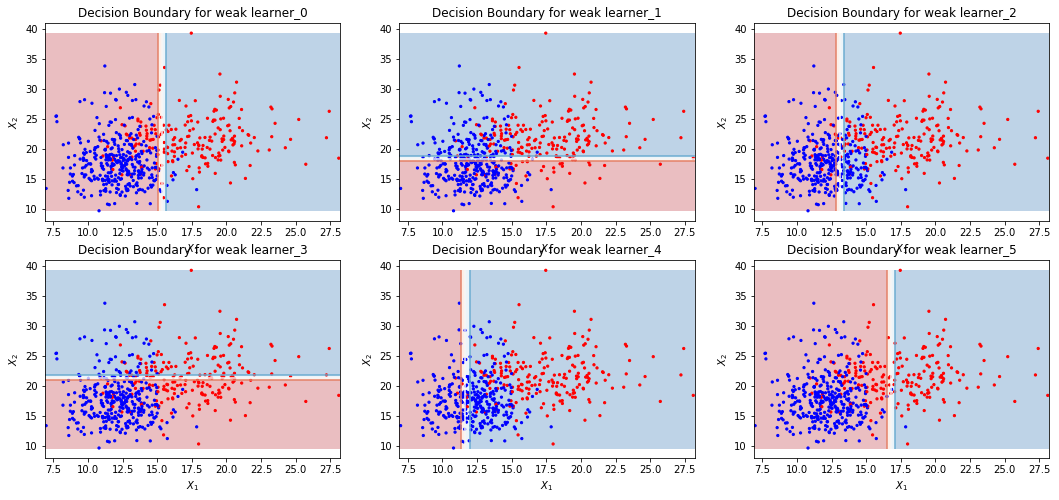

In [6]:
fig = plt.figure(figsize = (18,8))
for m in range(n_estimators):
    fig.add_subplot(int(n_estimators/3),3,m+1)
    #s_weights = (sample_weight_list[m,:] / sample_weight_list[m,:].sum() ) * 40
    plot_classification_contour_split(X, y, model, m)
    plt.title('Decision Boundary for weak learner_{}'.format(m))

Text(0.5, 1.0, 'Decision Boundary for strong learner_5')

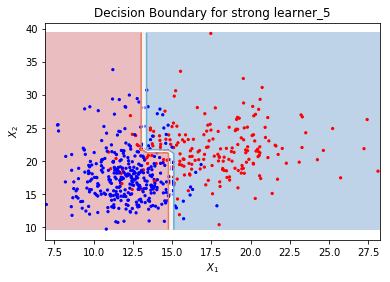

In [7]:
fig = plt.figure(figsize = (6,4))
plot_classification_contour(X, y, model)
plt.title('Decision Boundary for strong learner_{}'.format(m))